In [1]:
import pandas as pd

In [3]:
data=pd.read_csv("processed_data.csv")

In [4]:
X = data.copy()

In [5]:
y = X.pop('UACR')

In [6]:
print('These columns have only one value i.e. 0 or 1, so we can drop them')
for val in X.columns:
    if(len(X[val].value_counts())==1):
        print(val)

These columns have only one value i.e. 0 or 1, so we can drop them
Drug Addict
Dialysis
asthma
asthma_current
current_chronic bronchitis


In [7]:
X.drop(columns=['Drug Addict','Dialysis','asthma','asthma_current','current_chronic bronchitis'],inplace=True)

In [8]:
X.columns

Index(['Gender', 'Marital_status', 'Pregnant', 'current_drinker',
       'former_drinker_x', 'current_smoker', 'former_drinker_y', 'Aspirin_use',
       'High_Blood_pressure', 'High_Cholestrol', 'Chest_pain',
       'stomach problem', 'Chest Cold', 'Pneu_flu_ear infection', 'HIV',
       'Diabetes', 'Difficulty Hearing', 'Difficulty Seeing', 'Hepatitis_B',
       'Hepatitis_C', 'hospitalized', 'Weak Kidney', 'Kidney Stone',
       'Pesticide_used', 'anemia', 'overweight', 'blood_transfusion',
       'arthritis', 'gout', 'congestive heart failure',
       'coronary heart disease', 'heart attack', 'stroke', 'emphysema',
       'thyroid', 'chronic bronchitis', 'liver problem', 'COPD', 'jaundice',
       'cancer', 'kidney_cancer', 'Farmer', 'smoked_in_pregnancy',
       'Prescribed_medicine', 'HC2', 'HC3', 'HC4', 'HC5',
       'days_hospitalised_1', 'days_hospitalised_2', 'days_hospitalised_3',
       'days_hospitalised_4', 'days_hospitalised_5', 'days_hospitalised_6',
       'Age', 'Env_S

In [9]:
import statsmodels.api as sm
# takes input - X(feature vector), y(target variable)
# prints significant columns with(p-value<0.05)
# outputs new dataframe with only significant features
# remove print statements when not needed
def get_p_values_significant_features(X,y):
    X = sm.add_constant(X)
    ols_model = sm.OLS(y, X).fit()
    p_features = {}
    for i in X.columns.tolist():
        p_features[f'{i}'] = ols_model.pvalues[i]
    data_pvalue= pd.DataFrame(p_features.items(), columns=['Feature_name', 'p-Value']).sort_values(by = 'p-Value').reset_index(drop=True)
    print('*'*50)
    print('significant features')
    print('*'*50)
    print(data_pvalue[data_pvalue['p-Value']<0.05])
    significant_features = data_pvalue[data_pvalue['p-Value']<0.05]['Feature_name'].tolist()
    return X[significant_features]

# usage of get_p_values_significant_features
X_significant = get_p_values_significant_features(X,y)
print(X_significant)

**************************************************
significant features
**************************************************
                       Feature_name       p-Value
0                          Diabetes  1.835453e-38
1                       Weak Kidney  1.719359e-24
2                      heart attack  5.844099e-22
3                      Kidney Stone  3.060326e-14
4          congestive heart failure  1.888667e-10
5                         emphysema  8.199856e-09
6               days_hospitalised_5  1.873313e-07
7                        Chest_pain  3.370932e-05
8                            stroke  3.863883e-05
9                               Age  6.562183e-05
10                            const  9.813391e-05
11                 para-Nitrophenol  1.920579e-04
12              High_Blood_pressure  2.065908e-04
13                             gout  2.447367e-04
14                        arthritis  2.755482e-04
15          Dimethyldithiophosphate  3.307510e-04
16                         

In [10]:
from sklearn.model_selection import train_test_split
X_train_temp, X_holdout, y_train_temp, y_holdout = train_test_split(X_significant, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

#### X_train and y_train for training, X_dev and y_dev for hyperparameter tuning, X_valid and y_valid for validation, and X_test and y_test for testing. 

In [11]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC

def oversample_data(X, y, method='smote', sampling_strategy='auto', random_state=42):
    if method == 'smote':
        oversampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'borderline':
        oversampler = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'adasyn':
        oversampler = ADASYN(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'smotenc':
        categorical_features = [True] * X.shape[1]
        categorical_features[1] = False  # Age is not categorical
        oversampler = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=random_state)
    else:
        raise ValueError("Invalid oversampling method")

    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [12]:
from imblearn.over_sampling import SMOTE

# Step 1: SMOTE on the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

C:\Users\Supriya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Supriya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [15]:
best_params = grid_search.best_params_
best_logistic_model = grid_search.best_estimator_

In [16]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_valid = best_logistic_model.predict(X_valid)

print("Best Hyperparameters:", best_params)
print("Classification Report on Validation Set:\n", classification_report(y_valid, y_pred_valid))
print("Accuracy on Validation Set:", accuracy_score(y_valid, y_pred_valid))

Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81       495
           1       0.38      0.57      0.45       127

    accuracy                           0.72       622
   macro avg       0.63      0.66      0.63       622
weighted avg       0.77      0.72      0.74       622

Accuracy on Validation Set: 0.7218649517684887


In [17]:
y_pred_test = best_logistic_model.predict(X_test)

# Step 7: Display results on the test set
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred_test))
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_test))

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       514
           1       0.35      0.61      0.44       109

    accuracy                           0.73       623
   macro avg       0.62      0.68      0.63       623
weighted avg       0.80      0.73      0.76       623

Accuracy on Test Set: 0.7319422150882825


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # Assume X_train, X_valid, X_test, y_train, y_valid, y_test are your datasets

# # Train a logistic regression model
# model = LogisticRegression(random_state=42)
# model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_logistic_model.predict(X_train)

# Make predictions on the validation set
y_valid_pred = best_logistic_model.predict(X_valid)

# Make predictions on the test set
y_test_pred = best_logistic_model.predict(X_test)

# Evaluate on the training set
print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("ROC AUC Score:", roc_auc_score(y_train, best_logistic_model.predict_proba(X_train)[:, 1]))

# Evaluate on the validation set
print("\nValidation Set Metrics:")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Precision:", precision_score(y_valid, y_valid_pred))
print("Recall:", recall_score(y_valid, y_valid_pred))
print("F1 Score:", f1_score(y_valid, y_valid_pred))
print("ROC AUC Score:", roc_auc_score(y_valid, best_logistic_model.predict_proba(X_valid)[:, 1]))

# Evaluate on the test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, best_logistic_model.predict_proba(X_test)[:, 1]))


Training Set Metrics:
Accuracy: 0.7360428762840554
Precision: 0.35047067342505434
Recall: 0.6293888166449935
F1 Score: 0.45023255813953494
ROC AUC Score: 0.7512545486482289

Validation Set Metrics:
Accuracy: 0.7218649517684887
Precision: 0.37894736842105264
Recall: 0.5669291338582677
F1 Score: 0.4542586750788644
ROC AUC Score: 0.7312335958005249

Test Set Metrics:
Accuracy: 0.7319422150882825
Precision: 0.3473684210526316
Recall: 0.6055045871559633
F1 Score: 0.4414715719063545
ROC AUC Score: 0.7383357726769715


C:\Users\Supriya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Supriya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

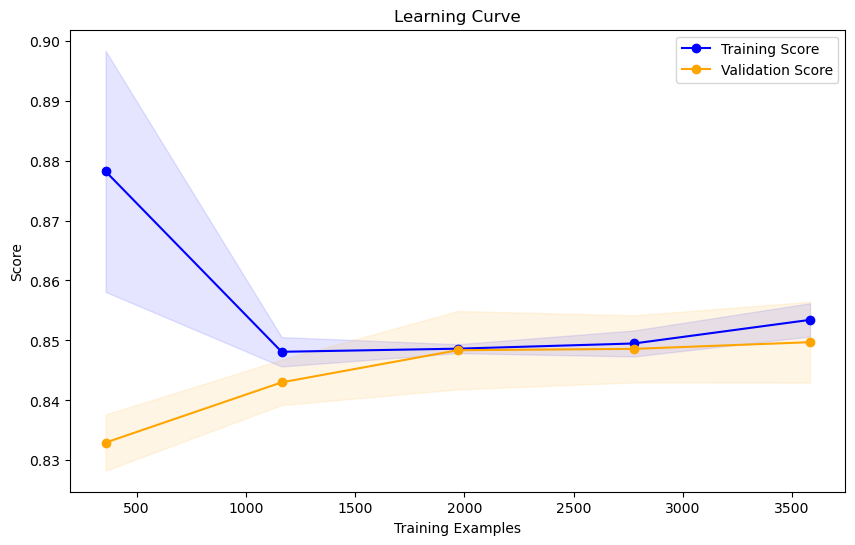

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X_train, y_train, X_valid, y_valid,cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Test Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

# Usage example
plot_learning_curve(best_logistic_model, X_train, y_train, X_test, y_test, cv=5)
